# Geneformer Fine-Tuning for PM2.5 exposure classification

In [ ]:
"""
PM2.5 Cell Classification Pipeline using Geneformer
Author: Guoqing Feng
Description: Preprocesses single-cell expression data and classifies cells using the Geneformer transformer model.
"""

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

In [ ]:
# Built-in
import os
import pickle
import datetime
from collections import Counter

# Scientific computing
import numpy as np
import pandas as pd
import scipy.sparse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# scRNA-seq handling
import scanpy as sc
import anndata as ad

# Machine learning
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

# HuggingFace Transformers
from transformers import (
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)

# HuggingFace Datasets
from datasets import load_from_disk, Dataset

# Geneformer specific
from geneformer import TranscriptomeTokenizer, DataCollatorForCellClassification
from geneformer.pretrainer import token_dictionary

In [82]:
#!pip install -r requirements.txt
#!pip install transformers==4.28.0
#!pip install --upgrade accelerate -U

# Prepare dataset from raw data to data format for Geneformer

In [ ]:
#read data
adata = sc.read_h5ad("path/to/your/data.h5ad")

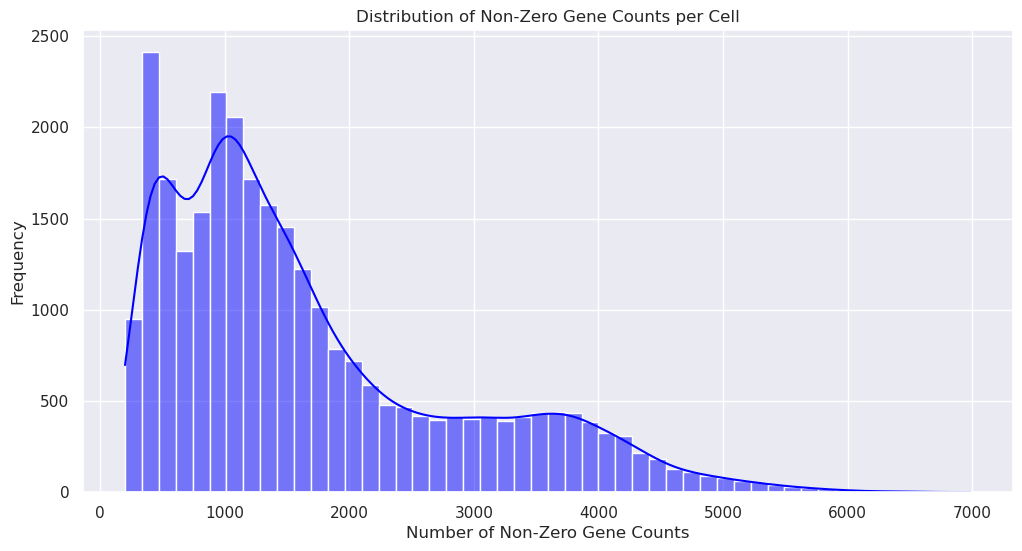

In [ ]:
# Check whether adata.X is a sparse matrix
if isinstance(adata.X, scipy.sparse.spmatrix):
    # Count non-zero elements per cell in a sparse matrix
    non_zero_counts = np.diff(adata.X.indptr)
else:
    # Count non-zero elements per cell in a dense matrix
    non_zero_counts = np.count_nonzero(adata.X, axis=1)

# Set figure size
plt.figure(figsize=(12, 6))

# Create histogram and density plot using seaborn
sns.histplot(non_zero_counts, kde=True, bins=50, color='blue')

# Set title and axis labels
plt.title('Distribution of Non-Zero Gene Counts per Cell')
plt.xlabel('Number of Non-Zero Gene Counts')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 28444 × 32285
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'specie', 'group', 'batchid', 'percent.mito', 'S.Score', 'G2M.Score', 'Phase', 'clusters', 'RNA_snn_res.0.4', 'seurat_clusters', 'RNA.tsne.res.0.4', 'raw_main_celltype', 'celltype', 'immgen.main.celltype', 'RNA_snn_res.1', 'RNA_snn_res.0.5', 'RNA_snn_res.1.5', 'celltype1'
    var: 'features'>

In [ ]:
adata.var

,features
Xkr4,Xkr4
Gm1992,Gm1992
Gm19938,Gm19938
Gm37381,Gm37381
Rp1,Rp1
...,...
AC124606.1,AC124606.1
AC133095.2,AC133095.2
AC133095.1,AC133095.1
AC234645.1,AC234645.1


In [ ]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,sampleid,specie,group,batchid,percent.mito,S.Score,G2M.Score,...,RNA_snn_res.0.4,seurat_clusters,RNA.tsne.res.0.4,raw_main_celltype,celltype,immgen.main.celltype,RNA_snn_res.1,RNA_snn_res.0.5,RNA_snn_res.1.5,celltype1
control_CONTROL_AAACCCAAGCATGCAG,AAACCCAAGCATGCAG-1,5543.0,1737,CONTROL,mm10,NULL,1,0.032654,0.014417,0.055616,...,3,7,4,T cells,T Cells,T cells,6,7,7,T cells
control_CONTROL_AAACCCAAGGGTCTTT,AAACCCAAGGGTCTTT-1,15877.0,3851,CONTROL,mm10,NULL,1,0.021352,-0.012081,-0.053509,...,4,5,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages
control_CONTROL_AAACCCAAGTGCCCGT,AAACCCAAGTGCCCGT-1,3956.0,1488,CONTROL,mm10,NULL,1,0.043984,0.069743,0.068740,...,3,7,4,T cells,T Cells,T cells,6,7,7,T cells
control_CONTROL_AAACCCACAAAGGCTG,AAACCCACAAAGGCTG-1,18883.0,3444,CONTROL,mm10,NULL,1,0.052693,-0.022540,-0.099783,...,6,19,7,Macrophages,Epithelium Cells,Epithelial cells,17,6,19,Epithelium Cells
control_CONTROL_AAACCCACAGGAGACT,AAACCCACAGGAGACT-1,3910.0,1431,CONTROL,mm10,NULL,1,0.017391,0.047794,-0.011127,...,13,12,14,NK cells,NK,NK cells,12,14,12,NK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PM25_PM2_5_TTTGTTGGTTGGCCGT,TTTGTTGGTTGGCCGT-2,12124.0,3134,PM2_5,mm10,NULL,1,0.062603,0.020137,-0.111346,...,4,5,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages
PM25_PM2_5_TTTGTTGTCAAATGCC,TTTGTTGTCAAATGCC-2,1676.0,671,PM2_5,mm10,NULL,1,0.019093,0.006764,-0.015578,...,2,3,3,Monocytes,Macrophages,Neutrophils,3,5,3,Macrophages
PM25_PM2_5_TTTGTTGTCACCCTGT,TTTGTTGTCACCCTGT-2,505.0,312,PM2_5,mm10,NULL,1,0.017822,-0.024898,-0.053948,...,5,8,6,Stromal cells,Stromal Cells,Fibroblasts,4,3,8,Fibroblast
PM25_PM2_5_TTTGTTGTCGCGTGAC,TTTGTTGTCGCGTGAC-2,19216.0,3678,PM2_5,mm10,NULL,1,0.036428,-0.064468,-0.089405,...,11,11,12,Endothelial cells,Epithelium Cells,Epithelial cells,10,12,11,Epithelium Cells


In [ ]:
### Delete non-homologous genes

# Assume you already have an AnnData object named 'adata'
# and a list of gene names to be removed named 'genes_to_remove'

# Read the gene list to remove
genelist_na_df = pd.read_csv("./genelist_remove.csv")

# Convert the 'x' column to a list of gene names
genes_to_remove = genelist_na_df["x"].tolist()

# Identify genes to keep (not in the removal list)
genes_to_keep = [gene for gene in adata.var_names if gene not in genes_to_remove]

# Subset the AnnData object to retain only the selected genes
adata_subset = adata[:, genes_to_keep]

# Now 'adata_subset' contains only the genes you want to keep

In [ ]:
adata_subset.var

,features
Xkr4,Xkr4
Rp1,Rp1
Sox17,Sox17
Mrpl15,Mrpl15
Lypla1,Lypla1
...,...
Usp9y,Usp9y
Vamp7,Vamp7
Spry3,Spry3
Tmlhe,Tmlhe


In [ ]:
genelist_emsemble_id = pd.read_csv("./genelist_ensemle_ids.csv")
genelist_emsemble_id

,genelist,converted_alias
0,Xkr4,ENSG00000206579
1,Rp1,ENSG00000104237
2,Sox17,ENSG00000164736
3,Mrpl15,ENSG00000137547
4,Lypla1,ENSG00000120992
...,...,...
15714,Usp9y,ENSG00000114374
15715,Vamp7,ENSG00000124333
15716,Spry3,ENSG00000168939
15717,Tmlhe,ENSG00000185973


In [ ]:
# Set 'genelist' as the index of genelist_emsemble_id (if not already set)
genelist_emsemble_id.set_index('genelist', inplace=True)

# If the common key in adata_subset.var is not already the index, set 'features' as the index
adata_subset.var.set_index('features', inplace=True)

In [ ]:
# Join the 'converted_alias' column from genelist_emsemble_id into adata_subset.var
adata_subset.var = adata_subset.var.join(genelist_emsemble_id['converted_alias'])

# Display the updated var dataframe
adata_subset.var

,converted_alias
features,
Xkr4,ENSG00000206579
Rp1,ENSG00000104237
Sox17,ENSG00000164736
Mrpl15,ENSG00000137547
Lypla1,ENSG00000120992
...,...
Usp9y,ENSG00000114374
Vamp7,ENSG00000124333
Spry3,ENSG00000168939


In [ ]:
# make dataset suitable for Geneformer
# convert row attributes to Ensembl IDs
adata_subset.var.rename(columns={"converted_alias": "ensembl_id"}, inplace=True)
adata_subset.var

,ensembl_id
features,
Xkr4,ENSG00000206579
Rp1,ENSG00000104237
Sox17,ENSG00000164736
Mrpl15,ENSG00000137547
Lypla1,ENSG00000120992
...,...
Usp9y,ENSG00000114374
Vamp7,ENSG00000124333
Spry3,ENSG00000168939


In [ ]:
#check if there are any NA values in the 'ensembl_id' column
column_name = 'ensembl_id'  

na_exists = adata_subset.var[column_name].isnull().any()

if na_exists:
    print(f"Column '{column_name}' contains NA values.")
else:
    print(f"Column '{column_name}' does not contain any NA values.")

Column 'ensembl_id' does not contain any NA values.


In [ ]:
# make dataset suitable for Geneformer
adata_subset.obs.rename(columns= {"nCount_RNA": "n_counts"}, inplace=True)
adata_subset.obs.rename(columns= {"sampleid": "sample_label"}, inplace=True)
adata_subset.obs

,orig.ident,n_counts,nFeature_RNA,sample_label,specie,group,batchid,percent.mito,S.Score,G2M.Score,...,RNA_snn_res.0.4,seurat_clusters,RNA.tsne.res.0.4,raw_main_celltype,celltype,immgen.main.celltype,RNA_snn_res.1,RNA_snn_res.0.5,RNA_snn_res.1.5,celltype1
control_CONTROL_AAACCCAAGCATGCAG,AAACCCAAGCATGCAG-1,5543.0,1737,CONTROL,mm10,NULL,1,0.032654,0.014417,0.055616,...,3,7,4,T cells,T Cells,T cells,6,7,7,T cells
control_CONTROL_AAACCCAAGGGTCTTT,AAACCCAAGGGTCTTT-1,15877.0,3851,CONTROL,mm10,NULL,1,0.021352,-0.012081,-0.053509,...,4,5,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages
control_CONTROL_AAACCCAAGTGCCCGT,AAACCCAAGTGCCCGT-1,3956.0,1488,CONTROL,mm10,NULL,1,0.043984,0.069743,0.068740,...,3,7,4,T cells,T Cells,T cells,6,7,7,T cells
control_CONTROL_AAACCCACAAAGGCTG,AAACCCACAAAGGCTG-1,18883.0,3444,CONTROL,mm10,NULL,1,0.052693,-0.022540,-0.099783,...,6,19,7,Macrophages,Epithelium Cells,Epithelial cells,17,6,19,Epithelium Cells
control_CONTROL_AAACCCACAGGAGACT,AAACCCACAGGAGACT-1,3910.0,1431,CONTROL,mm10,NULL,1,0.017391,0.047794,-0.011127,...,13,12,14,NK cells,NK,NK cells,12,14,12,NK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PM25_PM2_5_TTTGTTGGTTGGCCGT,TTTGTTGGTTGGCCGT-2,12124.0,3134,PM2_5,mm10,NULL,1,0.062603,0.020137,-0.111346,...,4,5,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages
PM25_PM2_5_TTTGTTGTCAAATGCC,TTTGTTGTCAAATGCC-2,1676.0,671,PM2_5,mm10,NULL,1,0.019093,0.006764,-0.015578,...,2,3,3,Monocytes,Macrophages,Neutrophils,3,5,3,Macrophages
PM25_PM2_5_TTTGTTGTCACCCTGT,TTTGTTGTCACCCTGT-2,505.0,312,PM2_5,mm10,NULL,1,0.017822,-0.024898,-0.053948,...,5,8,6,Stromal cells,Stromal Cells,Fibroblasts,4,3,8,Fibroblast
PM25_PM2_5_TTTGTTGTCGCGTGAC,TTTGTTGTCGCGTGAC-2,19216.0,3678,PM2_5,mm10,NULL,1,0.036428,-0.064468,-0.089405,...,11,11,12,Endothelial cells,Epithelium Cells,Epithelial cells,10,12,11,Epithelium Cells


In [ ]:
# add cell_type and organ_major columns for cell
adata_subset.obs['cell_type'] = adata_subset.obs['celltype1']
adata_subset.obs['organ_major'] = 'lung'
adata_subset.obs

,orig.ident,n_counts,nFeature_RNA,sample_label,specie,group,batchid,percent.mito,S.Score,G2M.Score,...,RNA.tsne.res.0.4,raw_main_celltype,celltype,immgen.main.celltype,RNA_snn_res.1,RNA_snn_res.0.5,RNA_snn_res.1.5,celltype1,cell_type,organ_major
control_CONTROL_AAACCCAAGCATGCAG,AAACCCAAGCATGCAG-1,5543.0,1737,CONTROL,mm10,NULL,1,0.032654,0.014417,0.055616,...,4,T cells,T Cells,T cells,6,7,7,T cells,T cells,lung
control_CONTROL_AAACCCAAGGGTCTTT,AAACCCAAGGGTCTTT-1,15877.0,3851,CONTROL,mm10,NULL,1,0.021352,-0.012081,-0.053509,...,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages,Macrophages,lung
control_CONTROL_AAACCCAAGTGCCCGT,AAACCCAAGTGCCCGT-1,3956.0,1488,CONTROL,mm10,NULL,1,0.043984,0.069743,0.068740,...,4,T cells,T Cells,T cells,6,7,7,T cells,T cells,lung
control_CONTROL_AAACCCACAAAGGCTG,AAACCCACAAAGGCTG-1,18883.0,3444,CONTROL,mm10,NULL,1,0.052693,-0.022540,-0.099783,...,7,Macrophages,Epithelium Cells,Epithelial cells,17,6,19,Epithelium Cells,Epithelium Cells,lung
control_CONTROL_AAACCCACAGGAGACT,AAACCCACAGGAGACT-1,3910.0,1431,CONTROL,mm10,NULL,1,0.017391,0.047794,-0.011127,...,14,NK cells,NK,NK cells,12,14,12,NK,NK,lung
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PM25_PM2_5_TTTGTTGGTTGGCCGT,TTTGTTGGTTGGCCGT-2,12124.0,3134,PM2_5,mm10,NULL,1,0.062603,0.020137,-0.111346,...,5,Macrophages,Macrophages,Macrophages,2,2,5,Macrophages,Macrophages,lung
PM25_PM2_5_TTTGTTGTCAAATGCC,TTTGTTGTCAAATGCC-2,1676.0,671,PM2_5,mm10,NULL,1,0.019093,0.006764,-0.015578,...,3,Monocytes,Macrophages,Neutrophils,3,5,3,Macrophages,Macrophages,lung
PM25_PM2_5_TTTGTTGTCACCCTGT,TTTGTTGTCACCCTGT-2,505.0,312,PM2_5,mm10,NULL,1,0.017822,-0.024898,-0.053948,...,6,Stromal cells,Stromal Cells,Fibroblasts,4,3,8,Fibroblast,Fibroblast,lung
PM25_PM2_5_TTTGTTGTCGCGTGAC,TTTGTTGTCGCGTGAC-2,19216.0,3678,PM2_5,mm10,NULL,1,0.036428,-0.064468,-0.089405,...,12,Endothelial cells,Epithelium Cells,Epithelial cells,10,12,11,Epithelium Cells,Epithelium Cells,lung


In [ ]:
adata_subset.write_loom("./output_PM25/processed_data.loom")

# Tokenize the dataset into a format compatible with Geneformer

In [ ]:
tk = TranscriptomeTokenizer({"cell_type": "cell_type", "organ_major": "organ_major", "sample_label": "sample_label"}, nproc=8)
tk.tokenize_data("./output_PM25", output_directory="token_data/", output_prefix="tk_PM25")


# Load tokenized dataset

In [ ]:
# load dataset 
dataset=load_from_disk("./token_data/tk_PM25_hehai.dataset")

In [ ]:
# Standardize the values in the 'sample_label' column

df = pd.DataFrame(dataset)

# Replace values in the 'sample_label' column
df['sample_label'] = df['sample_label'].replace({'CONTROL': 'C', 'PM2_5': 'P'})

# Convert the modified DataFrame back to a HuggingFace Dataset
dataset = datasets.Dataset.from_pandas(df)

In [ ]:
dataset.save_to_disk("./token_data/tk_PM25.dataset")

In [ ]:
### 统一细胞类型
# 定义一个函数来转换 cell_type 列中的值
def unify_Fibroblast(example):
    if example["cell_type"] in ["Fibroblast", "Fibroblasts"]:
        example["cell_type"] = "Fibroblasts"
    return example

def unify_Epitheliums(example):
    if example["cell_type"] in ["Epithelium Cells", "Epithelial cells"]:
        example["cell_type"] = "Epitheliums"
    return example

def unify_NKs(example):
    if example["cell_type"] in ["NK", "NK cells"]:
        example["cell_type"] = "NKs"
    return example

def unify_Endotheliums(example):
    if example["cell_type"] in ["Endothelial Cells", "Endothelial cells"]:
        example["cell_type"] = "Endotheliums"
    return example

# 使用 map 方法应用转换函数
dataset = dataset.map(unify_Fibroblast)
dataset = dataset.map(unify_Epitheliums)
dataset = dataset.map(unify_NKs)
dataset = dataset.map(unify_Endotheliums)


Map: 100%|██████████| 24231/24231 [00:01<00:00, 17997.89 examples/s]


In [ ]:
from collections import Counter

cell_types = dataset["cell_type"]

cell_type_counts = Counter(cell_types)

for cell_type, count in cell_type_counts.items():
    print(f"{cell_type}: {count}")

Macrophages: 4204
Epitheliums: 1651
Fibroblasts: 3070
Monocytes: 1049
T cells: 6497
DC: 309
Neutrophils: 1252
B cells: 1926
Endotheliums: 954
NKs: 926
ILC: 368
Unknown: 7
NKT: 1849
Stromal cells: 169


# Perform post-processing on the dataset: filtering cell types

In [ ]:
# Define a filtering function for specific cell types
cell_types = None  # e.g., ["Epithelium Cells"]

def filter_cell_types(example):
    return example['cell_type'] in cell_types

if cell_types is not None:
    # Apply the filtering function using the .filter() method
    filtered_dataset = dataset.filter(filter_cell_types)
else:
    # If no filtering is needed, use the original dataset
    filtered_dataset = dataset

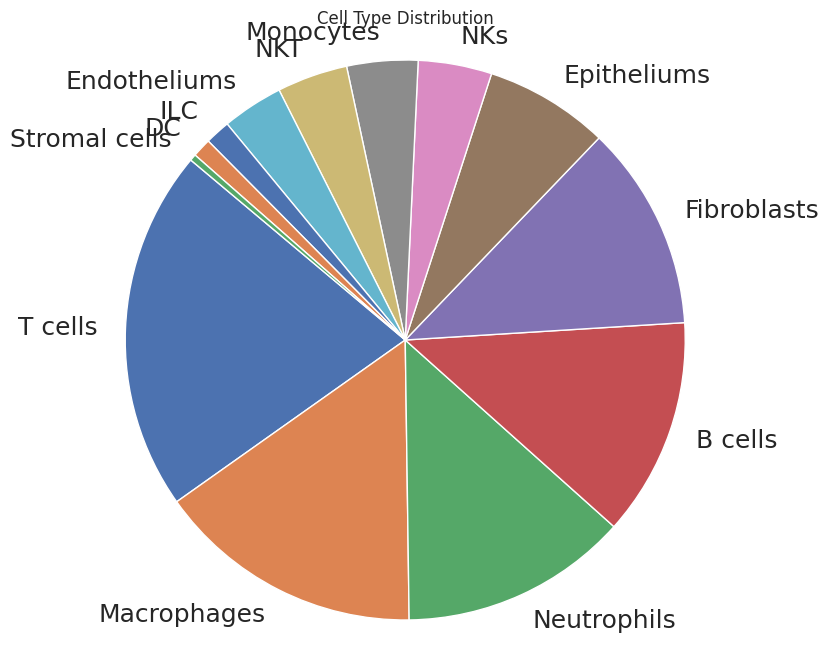

In [ ]:
# 饼图展现数据分布
import matplotlib.pyplot as plt

# 细胞类型分布数据
cell_type_distribution = {
    'T cells': 9483,
    'Macrophages': 6991,
    'Neutrophils': 5969,
    'B cells': 5713,
    'Fibroblasts': 5370,
    'Epitheliums': 3255,
    'NKs': 1927,
    'Monocytes': 1859,
    'NKT': 1849,
    'Endotheliums': 1602,
    'ILC': 657,
    'DC': 496,
    'Stromal cells': 169
}

# 提取标签和对应的值
labels = list(cell_type_distribution.keys())
sizes = list(cell_type_distribution.values())

# 绘制饼图
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, startangle=140, textprops={'fontsize': 18})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Cell Type Distribution')

# 保存为SVG文件
plt.savefig('cell_type_distribution.svg', format='svg')

plt.show()



# Perform post-processing on the dataset: padding

In [ ]:
#把length统一padding到2048
from geneformer.pretrainer import token_dictionary

def preprocess_classifier_batch(cell_batch, max_len):
    if max_len == None:
        max_len = max([len(i) for i in cell_batch["input_ids"]])
    def pad_label_example(example):
        example["input_ids"] = np.pad(example["input_ids"], 
                                      (0, max_len-len(example["input_ids"])), 
                                      mode='constant', constant_values=token_dictionary.get("<pad>"))
        example["attention_mask"] = (example["input_ids"] != token_dictionary.get("<pad>")).astype(int)
        return example
    padded_batch = cell_batch.map(pad_label_example)
    return padded_batch

# padded to be the same length.
set_len=len(dataset)
max_set_len = max(dataset.select([i for i in range(set_len)])["length"])
padded_dataset = preprocess_classifier_batch(dataset, max_set_len)

Map: 100%|██████████| 24231/24231 [00:22<00:00, 1063.75 examples/s]


In [ ]:
padded_dataset.save_to_disk("./token_data/tk_PM25_combined_celltype_revised_padded3.dataset")

Saving the dataset (0/1 shards):   0%|          | 0/24231 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 24231/24231 [00:00<00:00, 169120.60 examples/s]


# Randomly sample a specified number of cells

In [ ]:
from datasets import Dataset
import random

random.seed(42)

sampled_indices = random.sample(range(len(padded_dataset)), 2000)
sampled_dataset = padded_dataset.select(sampled_indices)

In [138]:
padded_dataset = sampled_dataset
padded_dataset

Dataset({
    features: ['input_ids', 'cell_type', 'organ_major', 'sample_label', 'length', 'attention_mask'],
    num_rows: 2000
})

# Map dataset labels: {'C': 0, 'P': 1}

In [ ]:
dataset_list = []
evalset_list = []
disease_list = []
target_dict_list = []

disease_list = Counter(padded_dataset["cell_type"]).keys()

# shuffle datasets and rename columns
trainset_disease_shuffled = padded_dataset.shuffle(seed=42)
trainset_disease_shuffled = trainset_disease_shuffled.rename_column("sample_label","label")
#trainset_disease_shuffled = trainset_disease_shuffled.remove_columns("organ_major")

# create dictionary of cell types : label ids
target_name_id_dict = {'C': 0, 'P': 1}
print(target_name_id_dict)
# change labels to numerical ids
def classes_to_ids(example):
    example["label"] = target_name_id_dict[example["label"]]
    return example
labeled_trainset = trainset_disease_shuffled.map(classes_to_ids, num_proc=16)

# Util func:compute_metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # calculate accuracy and macro f1 using sklearn's function
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average='macro')
    return {
      'accuracy': acc,
      'macro_f1': macro_f1
    }

# Geneformer fine-tuning with 5-fold cross-validation and three data curation strategies; freeze layers 0, 2, and 4

In [ ]:
padded_dataset_list = [padded_dataset1, padded_dataset2, padded_dataset3]
freeze_layers_list = [0, 2, 4]

In [ ]:
for freeze_layers in freeze_layers_list:
    for i in range(3):
        padded_dataset = padded_dataset_list[i]
        dataset_number = i+1
        
        dataset_list = []
        evalset_list = []
        disease_list = []
        target_dict_list = []

        disease_list = Counter(padded_dataset["cell_type"]).keys()

        # shuffle datasets and rename columns
        trainset_disease_shuffled = padded_dataset.shuffle(seed=42)
        trainset_disease_shuffled = trainset_disease_shuffled.rename_column("sample_label","label")
        #trainset_disease_shuffled = trainset_disease_shuffled.remove_columns("organ_major")

        # create dictionary of cell types : label ids
        target_name_id_dict = {'C': 0, 'P': 1}
        print(target_name_id_dict)
        # change labels to numerical ids
        def classes_to_ids(example):
            example["label"] = target_name_id_dict[example["label"]]
            return example
        labeled_trainset = trainset_disease_shuffled.map(classes_to_ids, num_proc=16)



        from sklearn.model_selection import KFold
        import numpy as np

        # set model parameters
        # max input size
        max_input_size = 2 ** 11  # 2048

        # set training hyperparameters
        # max learning rate
        max_lr = 5e-5
        # how many pretrained layers to freeze
        freeze_layers = freeze_layers
        # number gpus
        num_gpus = 4
        # number cpu cores
        num_proc = 32
        # batch size for training and eval
        geneformer_batch_size = 26
        # learning schedule
        lr_schedule_fn = "linear"
        # warmup steps
        warmup_steps = 500
        # number of epochs
        epochs = 50
        # optimizer
        optimizer = "adamw"


        kf = KFold(n_splits=5, shuffle=True, random_state=43)
        splits = list(kf.split(labeled_trainset))


        from transformers import BertForSequenceClassification, BertModel, EarlyStoppingCallback
        import torch
        import torch.nn as nn



        auc_scores = []
        roc_curves = []

        for fold, (train_index, val_index) in enumerate(splits):
            train_fold = labeled_trainset.select(train_index)
            val_fold = labeled_trainset.select(val_index)
            
            logging_steps = round(len(train_fold)/geneformer_batch_size/30)
            print(logging_steps)

            # Reload the model
            model = BertForSequenceClassification.from_pretrained("./Geneformer", 
                                                                num_labels=len(target_name_id_dict.keys()),
                                                                output_attentions=False,
                                                                output_hidden_states=False)
            if freeze_layers is not None:
                modules_to_freeze = model.bert.encoder.layer[:freeze_layers]
                for module in modules_to_freeze:
                    for param in module.parameters():
                        param.requires_grad = False
                        
            model = model.to("cuda")

            # Define output directory path
            current_date = datetime.datetime.now()
            datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
            output_dir = f"./models/data_curation/{datestamp}_geneformer_CellClassifier_PM25_dataset{dataset_number}_L{max_input_size}_B{geneformer_batch_size}_LR{max_lr}_LS{lr_schedule_fn}_WU{warmup_steps}_E{epochs}_O{optimizer}_F{freeze_layers}_fold{fold}/"
            
            # Ensure not overwriting previously saved model
            saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
            if os.path.isfile(saved_model_test):
                raise Exception("Model already saved to this directory.")
            
            # Make output directory
            os.makedirs(output_dir, exist_ok=True)
            
            # Set training arguments
            training_args = {
                "learning_rate": max_lr,
                "do_train": True,
                "do_eval": True,
                "evaluation_strategy": "epoch",
                "save_strategy": "epoch",
                "logging_steps": logging_steps,
                "group_by_length": True,
                "length_column_name": "length",
                "disable_tqdm": False,
                "lr_scheduler_type": lr_schedule_fn,
                "warmup_steps": warmup_steps,
                "weight_decay": 0.001,
                "per_device_train_batch_size": geneformer_batch_size,
                "per_device_eval_batch_size": geneformer_batch_size,
                "num_train_epochs": epochs,
                "load_best_model_at_end": True,
                "output_dir": output_dir,
            }
            
            training_args_init = TrainingArguments(**training_args)

            # Instantiate EarlyStoppingCallback
            early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
            
            # Create the trainer
            trainer = Trainer(
                model=model,
                args=training_args_init,
                data_collator=DataCollatorForCellClassification(),
                train_dataset=train_fold,
                eval_dataset=val_fold,
                compute_metrics=compute_metrics,
                callbacks=[early_stopping]
            )
            
            # Train the model
            trainer.train()
            
            # Evaluate the model
            predictions = trainer.predict(val_fold)
            
            # Compute AUC
            y_true = val_fold["label"]
            y_scores = predictions.predictions[:, 1]  
            auc = roc_auc_score(y_true, y_scores)
            auc_scores.append(auc)
            
            # Compute ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_curves.append((fpr, tpr))
            
            print(f"Fold {fold + 1}, AUC: {auc}")
            # Save metrics
            with open(f"{output_dir}predictions.pickle", "wb") as fp:
                pickle.dump(predictions, fp)
            trainer.save_metrics("eval", predictions.metrics)
            trainer.save_model(output_dir)

# Compare the performance of traditional machine learning models with the fine-tuned Geneformer model

## fine-tuned model

In [ ]:
padded_dataset = load_from_disk("path/to/your/data.dataset")
padded_dataset = padded_dataset.shuffle(seed=42).select(range(1000))

dataset_list = []
evalset_list = []
disease_list = []
target_dict_list = []

disease_list = Counter(padded_dataset["cell_type"]).keys()

# shuffle datasets and rename columns
trainset_disease_shuffled = padded_dataset.shuffle(seed=42)
trainset_disease_shuffled = trainset_disease_shuffled.rename_column("sample_label","label")
#trainset_disease_shuffled = trainset_disease_shuffled.remove_columns("organ_major")

# create dictionary of cell types : label ids
target_name_id_dict = {'C': 0, 'P': 1}
print(target_name_id_dict)
# change labels to numerical ids
def classes_to_ids(example):
    example["label"] = target_name_id_dict[example["label"]]
    return example
labeled_trainset = trainset_disease_shuffled.map(classes_to_ids, num_proc=16)



from sklearn.model_selection import KFold
import numpy as np

# set model parameters
max_input_size = 2 ** 11  # 2048
max_lr = 5e-5
num_gpus = 4
num_proc = 32
geneformer_batch_size = 26
lr_schedule_fn = "linear"
warmup_steps = 500
epochs = 50
optimizer = "adamw"

freeze_layers = 0

kf = KFold(n_splits=5, shuffle=True, random_state=43)
splits = list(kf.split(labeled_trainset))

auc_scores = []
roc_curves = []

for fold, (train_index, val_index) in enumerate(splits):
    train_fold = labeled_trainset.select(train_index)
    val_fold = labeled_trainset.select(val_index)
    
    logging_steps = round(len(train_fold)/geneformer_batch_size/30)
    print(logging_steps)

    model = BertForSequenceClassification.from_pretrained("./Geneformer", 
                                                        num_labels=2,
                                                        output_attentions = False,
                                                        #from_tf=True,
                                                        output_hidden_states = False)
    if freeze_layers is not None:
            modules_to_freeze = model.bert.encoder.layer[:freeze_layers]
            for module in modules_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
                    
    model = model.to("cuda")

    # Define output directory path
    current_date = datetime.datetime.now()
    datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
    output_dir = f"./models/5folds_allmodels/1000samples/fine_tuned/fold{fold}/"
    
    # Ensure not overwriting previously saved model
    saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
    if os.path.isfile(saved_model_test):
        raise Exception("Model already saved to this directory.")
    
    # Make output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Set training arguments
    training_args = {
        "learning_rate": max_lr,
        "do_train": True,
        "do_eval": True,
        "evaluation_strategy": "epoch",
        "save_strategy": "epoch",
        "logging_steps": logging_steps,
        "group_by_length": True,
        "length_column_name": "length",
        "disable_tqdm": False,
        "lr_scheduler_type": lr_schedule_fn,
        "warmup_steps": warmup_steps,
        "weight_decay": 0.001,
        "per_device_train_batch_size": geneformer_batch_size,
        "per_device_eval_batch_size": geneformer_batch_size,
        "num_train_epochs": epochs,
        "load_best_model_at_end": True,
        "output_dir": output_dir,
    }
    
    training_args_init = TrainingArguments(**training_args)

    # Instantiate EarlyStoppingCallback
    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
    
    # Create the trainer
    trainer = Trainer(
        model=model,
        args=training_args_init,
        data_collator=DataCollatorForCellClassification(),
        train_dataset=train_fold,
        eval_dataset=val_fold,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate the model
    predictions = trainer.predict(val_fold)
    
    # Compute AUC
    y_true = val_fold["label"]
    y_scores = predictions.predictions[:, 1]  
    auc = roc_auc_score(y_true, y_scores)
    auc_scores.append(auc)
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_curves.append((fpr, tpr))
    
    print(f"Fold {fold + 1}, AUC: {auc}")
    # Save metrics
    with open(f"{output_dir}predictions.pickle", "wb") as fp:
        pickle.dump(predictions, fp)
    trainer.save_metrics("eval", predictions.metrics)
    trainer.save_model(output_dir)

## 1/2/4/6 layer BERT

In [ ]:
from datasets import Dataset
import random

# Shuffle and select a fixed number of samples for evaluation
padded_dataset = padded_dataset.shuffle(seed=42).select(range(1000))

# Initialize containers
dataset_list = []
evalset_list = []
disease_list = []
target_dict_list = []

# Get list of cell types
disease_list = Counter(padded_dataset["cell_type"]).keys()

# Shuffle and prepare dataset
trainset_disease_shuffled = padded_dataset.shuffle(seed=42)
trainset_disease_shuffled = trainset_disease_shuffled.rename_column("sample_label", "label")
# trainset_disease_shuffled = trainset_disease_shuffled.remove_columns("organ_major")  # optional

# Define label mapping
target_name_id_dict = {'C': 0, 'P': 1}
print(target_name_id_dict)

# Convert class labels to numeric ids
def classes_to_ids(example):
    example["label"] = target_name_id_dict[example["label"]]
    return example

labeled_trainset = trainset_disease_shuffled.map(classes_to_ids, num_proc=16)

# Define model and training hyperparameters
max_input_size = 2 ** 11  # 2048
max_lr = 5e-5
num_gpus = 4
num_proc = 32
geneformer_batch_size = 26
lr_schedule_fn = "linear"
warmup_steps = 500
epochs = 50
optimizer = "adamw"

# Prepare 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=43)
splits = list(kf.split(labeled_trainset))

# Store results
auc_scores = []
roc_curves = []

for fold, (train_index, val_index) in enumerate(splits):
    train_fold = labeled_trainset.select(train_index)
    val_fold = labeled_trainset.select(val_index)

    logging_steps = round(len(train_fold) / geneformer_batch_size / 30)
    print(f"Fold {fold + 1} | Logging steps: {logging_steps}")

    num_hidden_layers = 1  # Using a custom lightweight BERT with 1 hidden layer

    # Define custom BERT configuration
    bert_config = BertConfig(
        hidden_size=256,
        num_hidden_layers=num_hidden_layers,
        num_attention_heads=4,
        intermediate_size=512,
        hidden_dropout_prob=0.02,
        attention_probs_dropout_prob=0.02,
        max_position_embeddings=2048,
        type_vocab_size=2,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        pad_token_id=0,
        position_embedding_type="absolute",
        use_cache=True,
        classifier_dropout=None,
        num_labels=len(target_name_id_dict)
    )

    # Initialize model and move to GPU
    model = BertForSequenceClassification(bert_config)
    model.init_weights()
    model = model.to("cuda")

    # Define output directory path
    current_date = datetime.datetime.now()
    datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
    output_dir = f"./models/5folds_allmodels/1000samples/L{num_hidden_layers}/fold{fold}/"

    # Prevent overwriting existing models
    saved_model_test = os.path.join(output_dir, "pytorch_model.bin")
    if os.path.isfile(saved_model_test):
        raise Exception("Model already saved to this directory.")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Set training arguments
    training_args = TrainingArguments(
        learning_rate=max_lr,
        do_train=True,
        do_eval=True,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_steps=logging_steps,
        group_by_length=True,
        length_column_name="length",
        disable_tqdm=False,
        lr_scheduler_type=lr_schedule_fn,
        warmup_steps=warmup_steps,
        weight_decay=0.001,
        per_device_train_batch_size=geneformer_batch_size,
        per_device_eval_batch_size=geneformer_batch_size,
        num_train_epochs=epochs,
        load_best_model_at_end=True,
        output_dir=output_dir
    )

    # Early stopping to avoid overfitting
    early_stopping = EarlyStoppingCallback(early_stopping_patience=2)

    # Create trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=DataCollatorForCellClassification(),
        train_dataset=train_fold,
        eval_dataset=val_fold,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping]
    )

    # Train model
    trainer.train()

    # Evaluate on validation set
    predictions = trainer.predict(val_fold)

    # Compute AUC score
    y_true = val_fold["label"]
    y_scores = predictions.predictions[:, 1]  # Assuming binary classification
    auc = roc_auc_score(y_true, y_scores)
    auc_scores.append(auc)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_curves.append((fpr, tpr))

    print(f"Fold {fold + 1}, AUC: {auc}")

    # Save predictions and metrics
    with open(f"{output_dir}predictions.pickle", "wb") as fp:
        pickle.dump(predictions, fp)
    trainer.save_metrics("eval", predictions.metrics)
    trainer.save_model(output_dir)

## RF

In [ ]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import LabelEncoder, label_binarize

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

# Machine learning model
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Persistence
import joblib  # For saving and loading models

In [ ]:
sampled_data = data.sample(n=4000, random_state=42)

In [ ]:
X = sampled_data.drop(columns=['label'])
y = sampled_data['label']

In [ ]:
# Encode string labels to numeric using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

# Set up 5-fold stratified cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)

# Lists to store TPRs and AUCs for each fold
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=60)

# Create directory to save models
model_dir = "./models/5folds_allmodels/max_dataset/random_forest"
os.makedirs(model_dir, exist_ok=True)

# Perform 5-fold cross-validation
fold = 1
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model on training fold
    clf.fit(X_train, y_train)

    # Save the model
    model_path = os.path.join(model_dir, f"random_forest_fold_{fold}.joblib")
    joblib.dump(clf, model_path)
    print(f"Model for fold {fold} saved at {model_path}")

    # Predict class probabilities
    y_probs = clf.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC for this fold
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    tprs.append(np.interp(mean_fpr, fpr, tpr))  # Interpolate TPRs to align on mean_fpr
    tprs[-1][0] = 0.0  # Ensure the curve starts at (0, 0)
    roc_auc = roc_auc_score(y_test, y_probs)
    aucs.append(roc_auc)
    print(f"AUC for fold {fold}: {roc_auc:.2f}")

    fold += 1

# Compute mean ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure the curve ends at (1, 1)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Plot mean ROC curve
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.svg', format='svg')
plt.show()

## SVM

In [7]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
import os

In [ ]:
# 5-fold Cross-Validation with Linear SVM

# Separate features and labels
X = data.drop(columns=['label'])
y = data['label']

# Encode string labels into numeric values
le = LabelEncoder()
y = le.fit_transform(y)

# Set up 5-fold stratified cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare storage for ROC curves and AUC values
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

# Create directory to save SVM models
model_dir = "./models/5folds_allmodels/max_dataset/SVM"
os.makedirs(model_dir, exist_ok=True)

# Perform cross-validation
fold = 1
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train linear SVM
    linear_svm = LinearSVC(random_state=42)
    linear_svm.fit(X_train, y_train)

    # Save the trained model
    model_path = os.path.join(model_dir, f"linear_svm_fold_{fold}.joblib")
    joblib.dump(linear_svm, model_path)
    print(f"Model for fold {fold} saved at {model_path}")

    # Predict decision scores (used for ROC)
    y_probs = linear_svm.decision_function(X_test)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = roc_auc_score(y_test, y_probs)
    aucs.append(roc_auc)
    print(f"AUC for fold {fold}: {roc_auc:.2f}")

    fold += 1

# Compute average ROC curve and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

# Plot the averaged ROC curve
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='b', lw=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend(loc='lower right')
plt.savefig('roc_curve_svm.svg', format='svg')
plt.show()

# Cross-cell-type classification

In [ ]:
from datasets import load_from_disk
padded_dataset = load_from_disk("path/to/your/data.dataset")

In [35]:
target_dict_list = []
# shuffle datasets and rename columns
padded_dataset_shuffled = padded_dataset.shuffle(seed=42)
padded_dataset_shuffled = padded_dataset_shuffled.rename_column("sample_label","label")
#trainset_disease_shuffled = trainset_disease_shuffled.remove_columns("organ_major")

# create dictionary of cell types : label ids
target_name_id_dict = {'C': 0, 'P': 1}
print(target_name_id_dict)
# change labels to numerical ids
def classes_to_ids(example):
    example["label"] = target_name_id_dict[example["label"]]
    return example
labeled_trainset = padded_dataset_shuffled.map(classes_to_ids, num_proc=16)

{'C': 0, 'P': 1}


In [ ]:
cell_type_list = ['T cells','Macrophages', 'Fibroblasts','Monocytes','Epitheliums','B cells','Neutrophils','NKT','Endotheliums', 'NKs']

In [39]:
from sklearn.model_selection import KFold
import numpy as np
from transformers import BertForSequenceClassification, BertModel, EarlyStoppingCallback
import torch
import torch.nn as nn

# set model parameters
# max input size
max_input_size = 2 ** 11  # 2048

# set training hyperparameters
# max learning rate
max_lr = 5e-5
# how many pretrained layers to freeze
freeze_layers = 2
# number gpus
num_gpus = 4
# number cpu cores
num_proc = 32
# batch size for training and eval
geneformer_batch_size = 26
# learning schedule
lr_schedule_fn = "linear"
# warmup steps
warmup_steps = 500
# number of epochs
epochs = 50
# optimizer
optimizer = "adamw"

In [ ]:
#split_datasets
#miss a function to split datasets
from datasets import Dataset, DatasetDict


def split_by_cell_type(dataset):
    cell_types = dataset.unique("cell_type")
    split_datasets = {}
    
    for cell_type in cell_types:
        cell_type_dataset = dataset.filter(lambda example: example['cell_type'] == cell_type)
        split_datasets[cell_type] = cell_type_dataset
    
    return split_datasets

split_datasets = split_by_cell_type(labeled_trainset)


In [ ]:
for cell_type in cell_type_list:
    
    test_dataset = split_datasets['NKs']
    test_dataset = test_dataset.shuffle(seed=42).select(range(900))
    
    train_datasets = [split_datasets[ct] for ct in cell_type_list if ct != cell_type]
    
    train_dataset = concatenate_datasets(train_datasets)
    # shuffle datasets
    train_dataset = train_dataset.shuffle(seed=42)

    # create dictionary of cell types : label ids
    target_name_id_dict = {'C': 0, 'P': 1}
    print(target_name_id_dict)


    kf = KFold(n_splits=5, shuffle=True, random_state=43)
    splits = list(kf.split(labeled_trainset))

    auc_scores = []
    roc_curves = []

    for fold, (train_index, val_index) in enumerate(splits):
        train_fold = labeled_trainset.select(train_index)
        val_fold = labeled_trainset.select(val_index)
        
        logging_steps = round(len(train_fold)/geneformer_batch_size/30)
        print(logging_steps)

        # Reload the model
        model = BertForSequenceClassification.from_pretrained(".", 
                                                            num_labels=len(target_name_id_dict.keys()),
                                                            output_attentions=False,
                                                            output_hidden_states=False)
        if freeze_layers is not None:
            modules_to_freeze = model.bert.encoder.layer[:freeze_layers]
            for module in modules_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
                    
        model = model.to("cuda")

        # Define output directory path
        current_date = datetime.datetime.now()
        datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
        output_dir = f"./models/data_diversity/fine-tuned/{cell_type}/fold{fold}/"
        
        # Ensure not overwriting previously saved model
        saved_model_test = os.path.join(output_dir, f"pytorch_model.bin")
        if os.path.isfile(saved_model_test):
            raise Exception("Model already saved to this directory.")
        
        # Make output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Set training arguments
        training_args = {
            "learning_rate": max_lr,
            "do_train": True,
            "do_eval": True,
            "evaluation_strategy": "epoch",
            "save_strategy": "epoch",
            "logging_steps": logging_steps,
            "group_by_length": True,
            "length_column_name": "length",
            "disable_tqdm": False,
            "lr_scheduler_type": lr_schedule_fn,
            "warmup_steps": warmup_steps,
            "weight_decay": 0.001,
            "per_device_train_batch_size": geneformer_batch_size,
            "per_device_eval_batch_size": geneformer_batch_size,
            "num_train_epochs": epochs,
            "load_best_model_at_end": True,
            "output_dir": output_dir,
        }
        
        training_args_init = TrainingArguments(**training_args)

        # Instantiate EarlyStoppingCallback
        early_stopping = EarlyStoppingCallback(early_stopping_patience=2)
        
        # Create the trainer
        trainer = Trainer(
            model=model,
            args=training_args_init,
            data_collator=DataCollatorForCellClassification(),
            train_dataset=train_fold,
            eval_dataset=val_fold,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping]
        )
        
        # Train the model
        trainer.train()
        
        # Evaluate the model
        predictions = trainer.predict(test_dataset)
        
        # Compute AUC
        y_true = test_dataset["label"]
        y_scores = predictions.predictions[:, 1]  
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)
        
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_curves.append((fpr, tpr))
        
        print(f"cell type : {cell_type},Fold {fold + 1}, AUC: {auc}")
        # Save metrics
        with open(f"{output_dir}predictions.pickle", "wb") as fp:
            pickle.dump(predictions, fp)
        trainer.save_metrics("eval", predictions.metrics)
        trainer.save_model(output_dir)

# figures for evaluating cross-cell-type performance


In [47]:
cell_type_list = ['T cells','Macrophages', 'Fibroblasts','Monocytes','Epitheliums','B cells',
 'Neutrophils','NKT','Endotheliums', 'NKs']

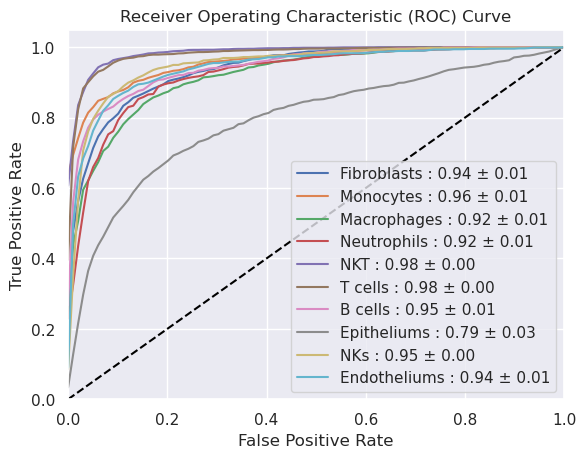

In [ ]:
# Define upper directory containing all model runs (e.g., from different data diversity experiments)
model_dir_upper = "./models/data_diversity/L6/"
model_dir_middle = os.listdir(model_dir_upper)

# Loop through each subfolder representing a model setting
for model_dir in model_dir_middle:
    model_dir_1 = model_dir_upper + model_dir + "/"

    # Paths to 5-fold cross-validation prediction files
    prediction_files = [
        model_dir_1 + 'fold0/predictions.pickle',
        model_dir_1 + 'fold1/predictions.pickle',
        model_dir_1 + 'fold2/predictions.pickle',
        model_dir_1 + 'fold3/predictions.pickle',
        model_dir_1 + 'fold4/predictions.pickle'
    ]

    all_fpr = []
    all_tpr = []
    roc_auc_scores = []

    # Load predictions and compute individual ROC curves and AUCs
    for prediction_file in prediction_files:
        with open(prediction_file, 'rb') as f:
            predictions = pickle.load(f)

        y_true = predictions.label_ids
        y_scores = predictions.predictions[:, 1]  # Use probability scores, not class labels

        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = roc_auc_score(y_true, y_scores)

        all_fpr.append(fpr)
        all_tpr.append(tpr)
        roc_auc_scores.append(roc_auc)

    # Compute mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(all_fpr, all_tpr):
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(all_fpr)

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(roc_auc_scores)

    # Plot each model's average ROC curve
    plt.plot(mean_fpr, mean_tpr, label=f'{model_dir} : {mean_auc:.2f} ± {std_auc:.2f}')

# Plot diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

# Plot formatting
plt.xlim([0, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Save the figure
plt.savefig("./figures/data_diversity_L6.svg", format='svg')
plt.show()

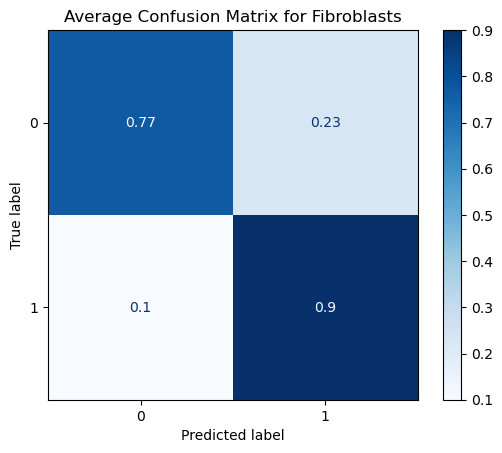

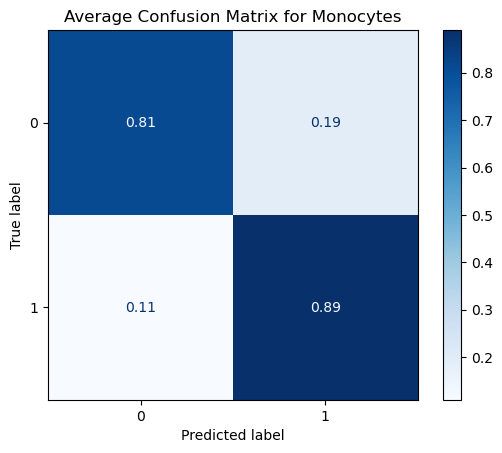

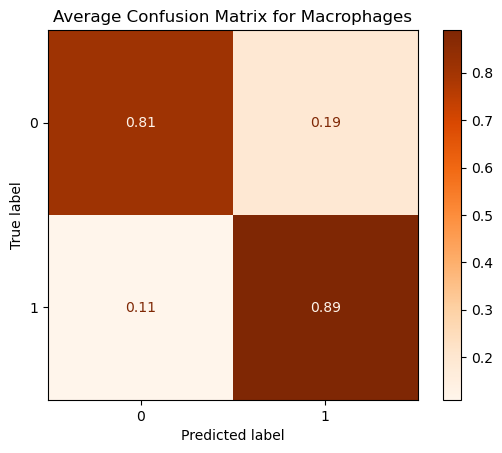

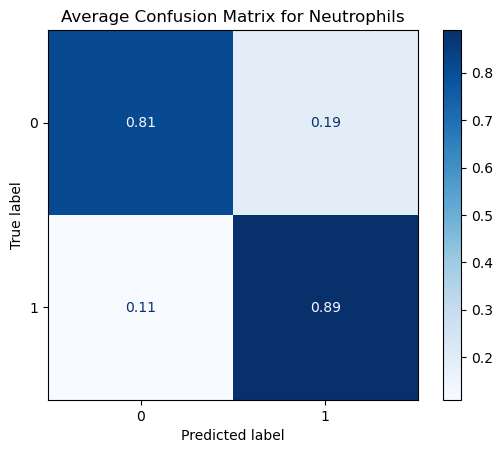

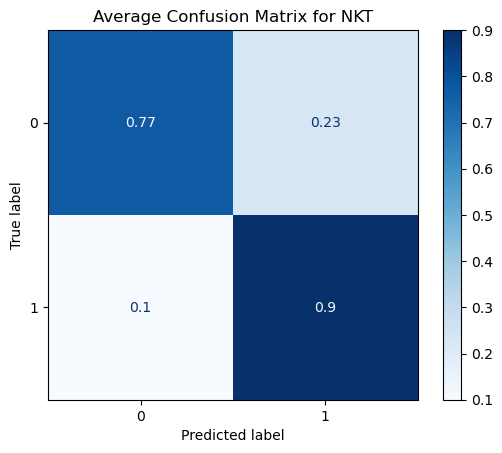

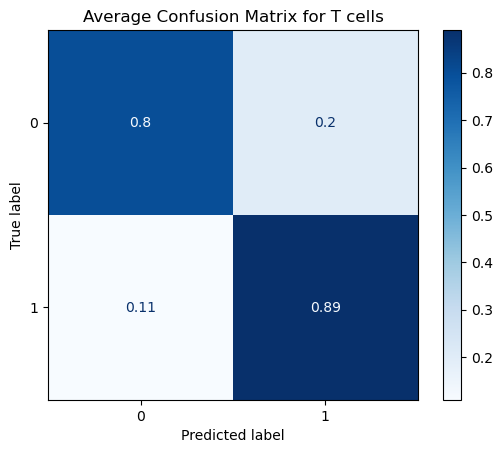

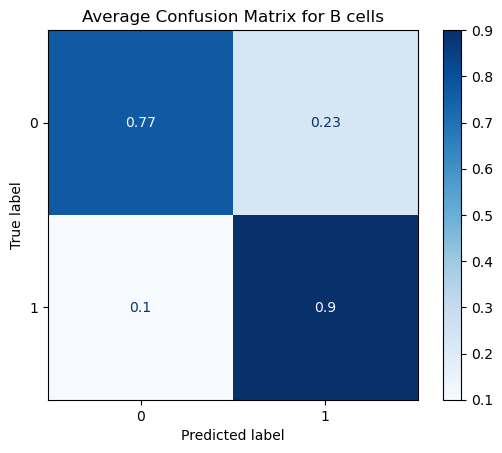

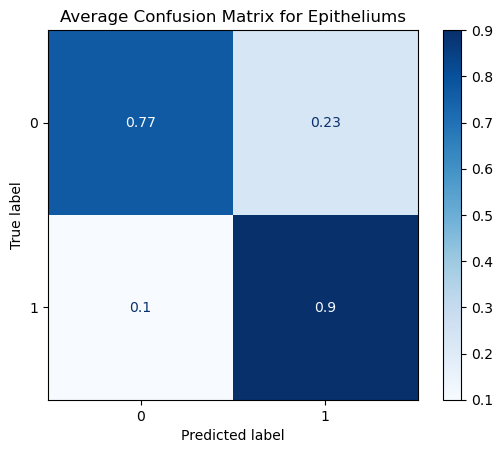

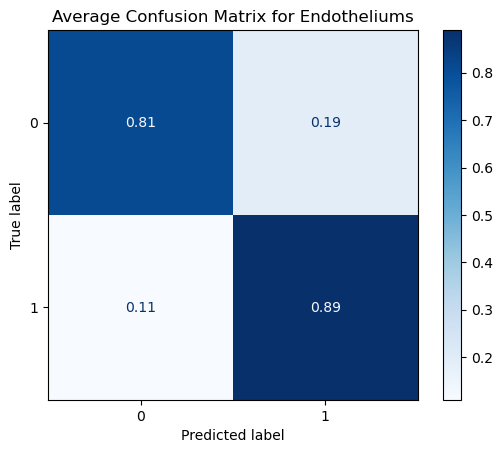

In [ ]:
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for model_dir in model_dir_middle:
    model_dir_1 = model_dir_upper + model_dir + "/"
    
    prediction_files = [
        model_dir_1 + 'fold0/predictions.pickle',
        model_dir_1 + 'fold1/predictions.pickle',
        model_dir_1 + 'fold2/predictions.pickle',
        model_dir_1 + 'fold3/predictions.pickle',
        model_dir_1 + 'fold4/predictions.pickle']
    
    all_conf_matrices = []

    for prediction_file in prediction_files:
        with open(prediction_file, 'rb') as f:
            predictions = pickle.load(f)
            
        y_true = predictions.label_ids
        y_pred = np.argmax(predictions.predictions, axis=1) 
        

        conf_matrix = confusion_matrix(y_true, y_pred)
        all_conf_matrices.append(conf_matrix)


    mean_conf_matrix = np.mean(all_conf_matrices, axis=0)
    

    row_sums = mean_conf_matrix.sum(axis=1, keepdims=True)
    normalized_conf_matrix = np.round(mean_conf_matrix / row_sums, 2)
    

    disp = ConfusionMatrixDisplay(confusion_matrix=normalized_conf_matrix)
    
    if model_dir == 'Macrophages':
        color = "Oranges"
    else:
        color = "Blues"
    
    disp.plot(cmap=color)


    plt.title(f'Average Confusion Matrix for {model_dir}')
    

    plt.savefig(f"./figures/{model_dir}_average_confusion_matrix_normalized.svg", format='svg')
    plt.show()

